In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier,Pool,cv



from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,f1_score


from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# underSampler=RandomUnderSampler()
overSampler=SMOTETomek(n_jobs=15)


import plotly.express as px

from sklearn.decomposition import PCA
pca=PCA()

from sklearn.preprocessing import StandardScaler
ss=StandardScaler()

In [2]:
data=pd.read_parquet('/home/hashmi/Files/DataFolder/ParticleBoxData/DownstreamData.parquet')

data=data[data['track_p']<100e3]


sample=data.sample(frac=0.01,random_state=46)
# sample=data.copy()

x=sample.drop(['Downstream',],axis=1)
y=sample['Downstream'].map({True:1,False:0})


In [3]:
indices=[]
for column,values in x.iteritems():
    

    q1=values.quantile(0.25)
    q3=values.quantile(0.75)
    iqr=q3-q1
    uWhiskerValue=q3+(1.5*iqr)
    lWhiskerValue=q1-(1.5*iqr)
    index=[]
    index.append((values[values>uWhiskerValue].index))
    index.append((values[values<uWhiskerValue].index))
    
    indices.append(index)
    
for i in range(12):
    sample.drop(index=indices[i][0],inplace=True,errors='ignore')

In [4]:
x=sample.drop(['Downstream',],axis=1)
y=sample['Downstream'].map({True:1,False:0})
x.track_nLHCbIDs=x.track_nLHCbIDs.astype('int')

In [5]:
x_train,x_test,y_train,y_test=train_test_split(x,y,shuffle=True,stratify=y,random_state=29,test_size=0.3)

# x_train=ss.fit_transform(x_train)
# x_test=ss.transform(x_test)

x_train,y_train=overSampler.fit_resample(X=x_train,y=y_train)
# x_test,y_test=overSampler.fit_resample(x_test,y_test)


train_data=Pool(data=x_train,label=y_train)
test_data=Pool(data=x_test,label=y_test)

In [6]:
model=CatBoostClassifier(eval_metric='F1',verbose=100,thread_count=15)

model.fit(train_data,eval_set=test_data,use_best_model=False,plot=True,verbose=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.066932
0:	learn: 0.6714467	test: 0.4732515	best: 0.4732515 (0)	total: 70.1ms	remaining: 1m 9s
100:	learn: 0.7370903	test: 0.4925505	best: 0.4929303 (79)	total: 983ms	remaining: 8.75s
200:	learn: 0.7517063	test: 0.5007094	best: 0.5008388 (198)	total: 1.76s	remaining: 7.01s
300:	learn: 0.7651032	test: 0.5073766	best: 0.5083616 (290)	total: 2.55s	remaining: 5.91s
400:	learn: 0.7745090	test: 0.5132532	best: 0.5137091 (397)	total: 3.36s	remaining: 5.02s
500:	learn: 0.7817598	test: 0.5134428	best: 0.5145063 (418)	total: 4.18s	remaining: 4.17s
600:	learn: 0.7879639	test: 0.5168221	best: 0.5177281 (597)	total: 4.98s	remaining: 3.3s
700:	learn: 0.7941039	test: 0.5198124	best: 0.5198124 (700)	total: 5.76s	remaining: 2.46s
800:	learn: 0.7999182	test: 0.5200712	best: 0.5210854 (768)	total: 6.57s	remaining: 1.63s
900:	learn: 0.8054536	test: 0.5197740	best: 0.5210854 (768)	total: 7.39s	remaining: 812ms
999:	learn: 0.8102830	test: 0.5207542	best: 0.5217151 (988)	total: 8.21s	re

In [7]:
# parameter_distribution = {'depth':[3,1,2,6,4,5,7,8,9,10],
#           'iterations':[250,100,500,1000],
#           'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
#           'l2_leaf_reg':[3,1,5,10,100],
#           'border_count':[32,5,10,20,50,100,200],
#           }


# random_search=model.randomized_search(X=x_train,y=y_train, param_distributions=parameter_distribution,plot=True)

# search=random_search['params']

# search

In [8]:
pred=model.predict(x_test)

print(accuracy_score(y_test,pred))
print(roc_auc_score(y_test,pred))
print(f1_score(y_test,pred))

0.7083841143097289
0.6960502407026778
0.5207541957317494


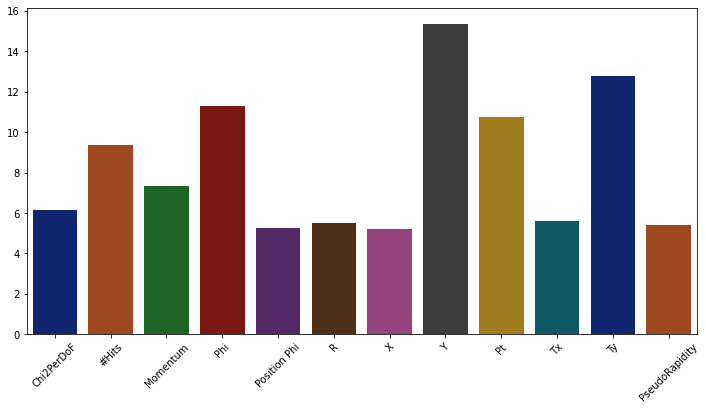

In [10]:
#FeaturImportance
columns=np.array(['Chi2PerDoF','#Hits','Momentum','Phi','Position Phi', 'R', 'X', 'Y', 'Pt','Tx','Ty','PseudoRapidity'])
plt.figure(figsize=(12,6))
sns.barplot(x=columns,y=model.feature_importances_,palette='dark')
plt.xticks(rotation=45)
# plt.savefig('./Plots/ClassifierPlots/FeatureImportance.eps',bbox_inches='tight')
plt.show()

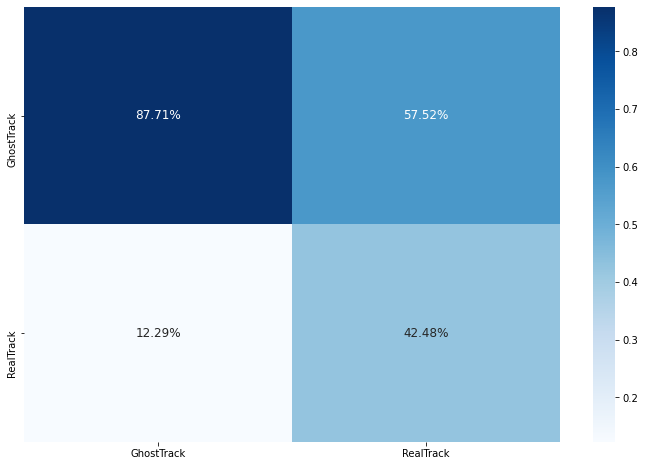

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test,pred,normalize='pred'),annot=True,xticklabels=['GhostTrack','RealTrack'],yticklabels=['GhostTrack','RealTrack'],fmt='.2%',annot_kws={'fontsize':12},cmap='Blues')
# plt.savefig('./Plots/ClassifierPlots/ConfusionMatrix.eps')
plt.show()

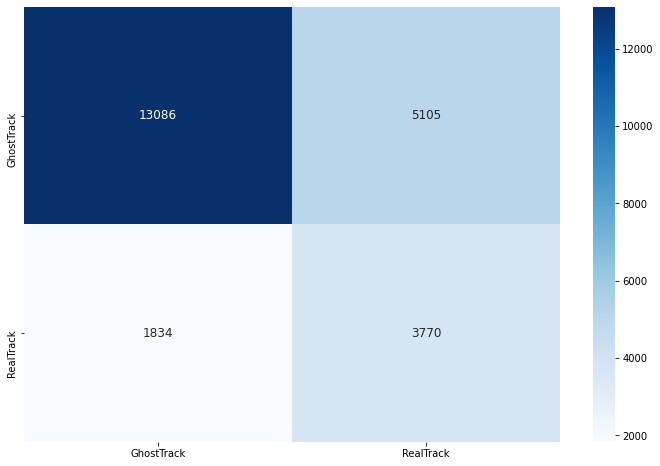

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test,pred),annot=True,xticklabels=['GhostTrack','RealTrack'],yticklabels=['GhostTrack','RealTrack'],fmt='d',annot_kws={'fontsize':12},cmap='Blues')
# plt.savefig('./Plots/ClassifierPlots/ConfusionMatrix2.eps')
plt.show()

In [13]:
test_sample=sample.sample(frac=0.01)


x=test_sample.drop('Downstream',axis=1)
y=test_sample['Downstream'].map({True:1,False:0})


x,y=overSampler.fit_resample(x,y)

x_train,x_test,y_train,y_test=train_test_split(x,y,shuffle=True,stratify=y,random_state=29)

In [14]:
Probability=[]
for i in tqdm(range(x_test.shape[0])):
    Probability.append(model.predict_proba(x_test)[i][0])
    


x_test['Probability']=Probability
x_test['Label']=y_test

x_test.head()

100%|██████████| 278/278 [00:00<00:00, 294.01it/s]


,track_chi2PerDoF,track_nLHCbIDs,track_p,track_phi,track_position_phi,track_position_r,track_position_x,track_position_y,track_pt,track_tx,track_ty,track_pseudoRapidity,Probability,Label
190,0.400042,11.0,5913.847591,2.689544,2.131648,867.633178,-461.500763,734.713806,1272.663517,-0.198229,0.096257,2.217548,0.180968,1
356,0.550240,12.0,8900.130276,-0.224004,-0.695423,307.002091,235.710953,-196.699341,1071.471537,0.118240,-0.026938,2.806537,0.572656,0
273,0.537931,12.0,3994.544588,-2.950487,-2.695857,1168.283425,-1054.135010,-503.672058,1354.667768,-0.353930,-0.068474,1.744443,0.357898,1
699,0.293575,12.0,4470.922694,0.056542,0.077084,686.825952,684.786438,52.890671,1171.677534,0.271123,0.015346,2.014676,0.714133,0
244,0.499399,10.0,10057.038380,0.803656,1.736061,563.706079,-92.737114,556.025513,1015.496908,0.070444,0.073064,2.983483,0.508984,0


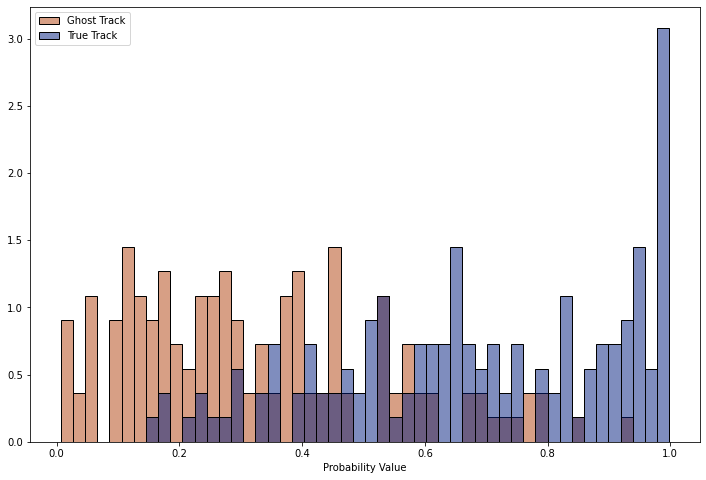

In [15]:
plt.figure(figsize=(12,8))
figure=sns.histplot(data=x_test,x='Probability',hue='Label',stat='density',bins=50,palette='dark')
plt.xlabel('Probability Value')
plt.ylabel('')
plt.legend(labels=['Ghost Track','True Track'])
# plt.savefig('./Plots/ClassifierPlots/Distribution.eps')
plt.show()

In [16]:
model.calc_feature_statistics(train_data)

{'track_chi2PerDoF': {'borders': array([0.06421076, 0.07315181, 0.08179874, 0.08855623, 0.09486887,
         0.10102645, 0.10606889, 0.11084013, 0.11612266, 0.1206892 ,
         0.12511298, 0.1299389 , 0.13393497, 0.14193553, 0.14553832,
         0.15293777, 0.15624785, 0.16294809, 0.16592214, 0.16913708,
         0.17224118, 0.17887485, 0.18220672, 0.18821926, 0.1913797 ,
         0.19450213, 0.19759265, 0.20392236, 0.20712513, 0.20992301,
         0.21298888, 0.21588106, 0.21882874, 0.22188014, 0.23358753,
         0.2368046 , 0.24264514, 0.24549823, 0.24820961, 0.25122094,
         0.25433165, 0.25694734, 0.26245892, 0.26805896, 0.2713397 ,
         0.28036708, 0.2832181 , 0.28624102, 0.29246613, 0.29552358,
         0.29894283, 0.30188477, 0.30469555, 0.30758023, 0.3162555 ,
         0.31951517, 0.32246125, 0.3284904 , 0.33172446, 0.33780432,
         0.34114367, 0.34430552, 0.35089797, 0.35434636, 0.3573018 ,
         0.36017907, 0.36327678, 0.37293184, 0.37588412, 0.38238296,
   